In [7]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


In [8]:
!pwd

/home/u42179/computer-pointer-controller/src


In [15]:
from IPython.display import HTML

HTML("""
    <video width="860" height="415"  alt="test" controls>
        <source src="../bin/demo.mp4" type="video/mp4">
    </video>
    """)


In [16]:
# %%capture
!python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name face-detection-adas-binary-0001 --output_dir ../models
!python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name head-pose-estimation-adas-0001 --output_dir ../models
!python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name landmarks-regression-retail-0009 --output_dir ../models
!python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name gaze-estimation-adas-0002 --output_dir ../models

################|| Downloading models ||################

========== Downloading ../models/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001.xml
... 100%, 113 KB, 2850 KB/s, 0 seconds passed

========== Downloading ../models/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001.bin
... 100%, 1797 KB, 28793 KB/s, 0 seconds passed

################|| Post-processing ||################

################|| Downloading models ||################

========== Downloading ../models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml
... 100%, 49 KB, 2950 KB/s, 0 seconds passed

========== Downloading ../models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.bin
... 100%, 7468 KB, 28623 KB/s, 0 seconds passed

========== Downloading ../models/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml
... 100%, 49 KB, 2801 KB/s, 0 seconds passed

========== Downloading ../mo

In [57]:
%%writefile queue_job.sh
#!/bin/bash

exec 1>output/stdout.log 2>output/stderr.log

mkdir -p $1
OUTPUT_FILE=$1
DEVICE=$2
PRECISION=$3
INPUT_FILE=$4
THRESHOLD=$5

if [ "$PRECISION" = "FP32" ]; then
    FACEMODELPATH=../models/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001.xml
    POSEMODELPATH=../models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml
    LANDMARKSMODELPATH=../models/intel/landmarks-regression-retail-0009/FP32/landmarks-regression-retail-0009.xml    
    GAZEMODELPATH=../models/intel/gaze-estimation-adas-0002/FP32/gaze-estimation-adas-0002.xml        
else
    FACEMODELPATH=../models/intel/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001.xml
    POSEMODELPATH=../models/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml
    LANDMARKSMODELPATH=../models/intel/landmarks-regression-retail-0009/FP16/landmarks-regression-retail-0009.xml    
    GAZEMODELPATH=../models/intel/gaze-estimation-adas-0002/FP16/gaze-estimation-adas-0002.xml        
fi

if echo "$DEVICE" | grep -q "FPGA"; then # if device passed in is FPGA, load bitstream to program FPGA
    #Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/intel/init_openvino.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/2019R4_PL1_FP16_MobileNet_Clamp.aocx
fi

python3 main-intel-dev.py -fm ${FACEMODELPATH} \
                -pm ${POSEMODELPATH} \
                -lm ${LANDMARKSMODELPATH} \
                -gm ${GAZEMODELPATH} \
                -i ${INPUT_FILE} \
                -o ${OUTPUT_FILE} \
                -d ${DEVICE} \
                -c ${THRESHOLD}


Overwriting queue_job.sh


## Submit to an Edge Compute Node with an Intel CPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload should run on the CPU.

NOTE: **Change precison to FP16 to run application with FP16**

In [16]:
# Run for CPU with Model precision = FP32
device = "CPU"
output_path = "output/results/fp16/cpu"
precision = "FP16"
thres=0.5
input_file = "../bin/demo.mp4"
params = ' {} {} {} {} {}'.format(output_path, device, precision, input_file, thres)

In [17]:
job_id = !qsub queue_job.sh -l nodes=1:tank-870:i5-6500te -d . -F "{params}" -N "cpu"

In [18]:
job_id

['3878.v-qsvr-2.devcloud-edge']

In [20]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
3819.v-qsvr-2              ...ub-singleuser u42179          00:01:47 R jupyterhub     


## Submit to an Edge Compute Node with a CPU and IGPU
In the cell below, write a script to submit a job to an <a href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload should run on the **Intel® HD Graphics 530** integrated GPU.

In [21]:
# Run for CPU with Model precision = FP32
device = "GPU"
output_path = "output/results/fp16/igpu"
precision = "FP16"
thres=0.5
input_file = "../bin/demo.mp4"
params = ' {} {} {} {} {}'.format(output_path, device, precision, input_file, thres)
node = "tank-870:i5-6500te:intel-hd-530"
job_name = "igpu"

In [22]:
job_id = !qsub queue_job.sh -l nodes=1:{node} -d . -F "{params}" -N {job_name}

In [23]:
job_id

['3879.v-qsvr-2.devcloud-edge']

In [24]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
3819.v-qsvr-2              ...ub-singleuser u42179          00:01:47 R jupyterhub     
3879.v-qsvr-2              igpu             u42179                 0 R batch          


## Submit to an Edge Compute Node with an Intel® Neural Compute Stick 2
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload should run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [25]:
# Run for CPU with Model precision = FP32
output_path = "output/results/fp16/vpu"
precision = "FP16"
thres=0.5
input_file = "../bin/demo.mp4"
params = ' {} {} {} {} {}'.format(output_path, device, precision, input_file, thres)
device = "MYRIAD"
node = "tank-870:i5-6500te:intel-ncs2"
job_name = "ncs2"

In [26]:
job_id = !qsub queue_job.sh -l nodes=1:{node} -d . -F "{params}" -N {job_name}

In [27]:
job_id

['3880.v-qsvr-2.devcloud-edge']

In [28]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
3819.v-qsvr-2              ...ub-singleuser u42179          00:01:47 R jupyterhub     
3880.v-qsvr-2              ncs2             u42179                 0 R batch          


## Submit to an Edge Compute Node with IEI Mustang-F100-A10
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> FPGA card installed in this node.

In [29]:
# Run for CPU with Model precision = FP32
output_path = "output/results/fp16/fpga"
precision = "FP16"
thres=0.5
input_file = "../bin/demo.mp4"
params = ' {} {} {} {} {}'.format(output_path, device, precision, input_file, thres)
device = "HETERO:FPGA,CPU"
node = "tank-870:i5-6500te:iei-mustang-f100-a10"
job_name = "fpga"


In [30]:
job_id = !qsub queue_job.sh -l nodes=1:{node} -d . -F "{params}" -N {job_name}

In [31]:
job_id

['3881.v-qsvr-2.devcloud-edge']

In [32]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
3819.v-qsvr-2              ...ub-singleuser u42179          00:01:48 R jupyterhub     
3881.v-qsvr-2              fpga             u42179                 0 R batch          


In [33]:
import matplotlib.pyplot as plt

device_list=['cpu', 'igpu', 'fpga', 'vpu']
inference_time=[]
fps=[]
model_load_time=[]

for device in device_list:
    with open('output/results/fp16/'+device+'/stats.txt', 'r') as f:
        inf_time = float(f.readline().split("\n")[0])
        inference_time.append(inf_time)
        fps.append(float(f.readline().split("\n")[0]) / inf_time)
        model_load_time.append(float(f.readline().split("\n")[0]))

In [34]:
inference_time

[19.8, 19.3, 21.4, 19.3]

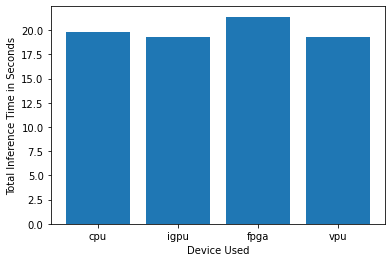

<Figure size 432x288 with 0 Axes>

In [35]:
plt.bar(device_list, inference_time)
plt.xlabel("Device Used")
plt.ylabel("Total Inference Time in Seconds")
plt.show()
plt.savefig('fp16_inference_time.png')

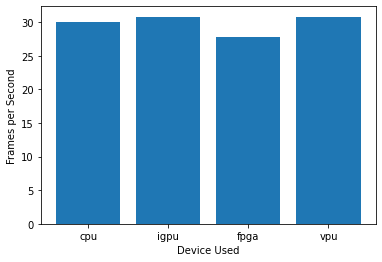

<Figure size 432x288 with 0 Axes>

In [36]:
plt.bar(device_list, fps)
plt.xlabel("Device Used")
plt.ylabel("Frames per Second")
plt.show()

plt.savefig('fp16_frames_ps.png')

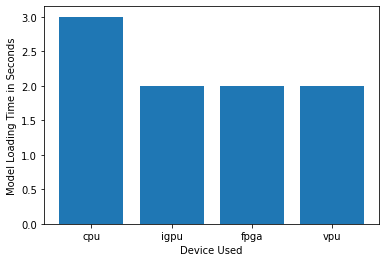

<Figure size 432x288 with 0 Axes>

In [37]:
plt.bar(device_list, model_load_time)
plt.xlabel("Device Used")
plt.ylabel("Model Loading Time in Seconds")
plt.show()
plt.savefig('fp16_model_load__time.png')

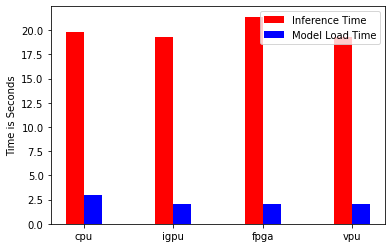

In [38]:
import numpy as np

fig = plt.figure()
p = fig.add_subplot(111)

width = 0.2
x = np.arange(len(device_list))
y1 = p.bar(x, inference_time, width=0.2, color='r', align='center')
y2 = p.bar(x + width, model_load_time, width=0.2, color='b', align='center')

p.set_ylabel('Time is Seconds')
p.set_xticks(x + width/2)
p.set_xticklabels(device_list)
p.legend( (y1[0], y2[0]), ('Inference Time', 'Model Load Time') )

plt.savefig('fp16_comparison.png')